## ***Load the Document***

In [1]:
from langchain_community.document_loaders import PyMuPDFLoader
import os
pdf_dir = "./deepLearning-book/chapter-3-to-8/"

In [2]:
pdf_files = [os.path.join(pdf_dir, file) for file in os.listdir(pdf_dir) if file.endswith(".pdf")]


In [3]:
# Load and combine all chapters
all_documents = []
for pdf_file in pdf_files:
    loader = PyMuPDFLoader(pdf_file)
    docs = loader.load()
    all_documents.extend(docs)

In [9]:
len(all_documents)

243

## **Semantic Chunking**

In [4]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
load_dotenv()

True

In [5]:
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [6]:
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

In [7]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

c:\Users\IT BD\anaconda3\envs\ailb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\IT BD\anaconda3\envs\ailb\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\IT BD\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` envi

In [13]:
len(embeddings.embed_query("Test"))

768

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

text_splitter = SemanticChunker(
    embeddings=embeddings,
    breakpoint_threshold_type="percentile",  # or "standard_deviation"
    breakpoint_threshold_amount=92.5,        # slightly more aggressive than 95.0 (default)
    min_chunk_size=300                       # ensures no tiny chunks
)


In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

In [11]:
chunk_docs = text_splitter.split_documents(all_documents)
len(chunk_docs)

1311

## *Vector Store*

In [12]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore import InMemoryDocstore

### 4 different indexing

In [21]:
# index = faiss.IndexFlat(768)
# index = faiss.IndexIVF(768)
# index = faiss.IndexHNSW(768)
index = faiss.IndexFlatL2(768)

In [22]:
## create VectorStore

vectoStore = FAISS(
    index=index,
    embedding_function=embeddings,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={}
    
)

In [23]:
vectoStore.add_documents(chunk_docs)

['8ef04a08-20aa-4f8e-96ed-bfc2a7163694',
 '3d80c047-f3a0-4318-a475-c9bd296fd920',
 'b6720430-c502-49e2-a5a6-3e259c7aedae',
 'ea2cfbd7-e469-40f8-a45d-da1abfc8acca',
 'a91c8340-6e9a-4f51-8c9d-0bc48264c65c',
 'ea2bb27f-5d2a-4977-8b3d-f4f0b80c1464',
 '3fc235dc-b78d-4ef8-874b-754684dfffbf',
 '66d75d27-b966-41b3-8277-1d4f65d14f0b',
 'e5babfd2-d2f2-4e22-bc67-ceb24d9c5e18',
 '1c52cc63-7e2c-45a2-87c8-e8d768de0ac1',
 'bfffe739-edbb-42b0-9fcf-43e4eac92315',
 '91b074a4-1500-468c-8b95-f635887ec26d',
 '27042b9e-5ada-41eb-a1b3-89ad60f5d5ab',
 'ec5bd754-bb91-44c2-a670-41179e1b7b21',
 '72a59385-8028-46d7-8951-b27a5d5baa8d',
 '36a32093-7906-4ab5-af1d-ebefbbdaafa3',
 '541157be-97c8-4d5b-9cb6-ed2b929f6052',
 'ddea3a5c-427a-459c-96c2-a428b7310c8c',
 '9a850acd-9c73-4e64-90c2-fe09acd2a981',
 '81a52cf5-c839-4f43-ac9c-140366214f81',
 '06a0baab-a41d-41a3-8b6f-1f7f569f88e6',
 '1815788a-2147-484a-adfb-65dc70b5a658',
 '27284cee-3ab0-4d03-b11a-2e1531360f5b',
 'a33f44d9-cf15-45ea-985f-123f232935b4',
 'd3ece887-57a6-

## save the db

In [24]:
vectoStore.save_local("d2l-vdb")

In [25]:
retriever = vectoStore.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

In [26]:
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [30]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    print(context_text)
    return context_text

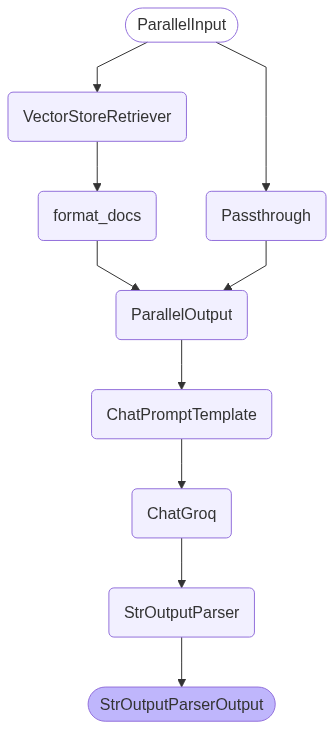

In [31]:
from IPython.display import display, Image

rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)


display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [32]:
rag_chain.invoke("Why multilayer perceptron is important?")

5
Multilayer Perceptrons
In this chapter, we will introduce your first truly deep network. The simplest deep networks
are called multilayer perceptrons, and they consist of multiple layers of neurons each fully
connected to those in the layer below (from which they receive input) and those above
(which they, in turn, influence). Although automatic differentiation significantly simplifies
the implementation of deep learning algorithms, we will dive deep into how these gradi-

192
Multilayer Perceptrons
any choice of the distance metric, we will achieve zero training error and eventually reach
an optimal predictor, but different distance metrics 𝑑encode different inductive biases and
with a finite amount of available data will yield different predictors. Different choices of
the distance metric 𝑑represent different assumptions about the underlying patterns and the
performance of the different predictors will depend on how compatible the assumptions are

173
Multilayer Perceptrons
When at

'Multilayer perceptrons are important because they are the simplest deep networks and represent a fundamental building block of deep learning. They consist of multiple layers of fully connected neurons, allowing them to learn complex patterns in data. This architecture enables multilayer perceptrons to achieve zero training error and reach optimal predictors with an appropriate choice of distance metric.'